In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#필요한 lib으로 한번만 하고, jupyter환경에선 다신 실행 안하셔도되고, colab에선 실행할 때마다 해주심 됩니다.
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=7e8dc34f2c82a86afa0d8d42e8f6fe7a0a1d54ba966583168afe1649016ebcfb
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.5 MB/s eta 0:00:00


In [3]:
# plt.style.available

In [4]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn-v0_8') # 이 위에 코드를 실행하면 여러 테마가 있으니 마음껏 바꾸셔도 됩니다.
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

from dateutil import tz

import shap
import skimage


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.options.display.max_columns = 400
pd.set_option('display.max_colwidth', None)

<Figure size 1600x800 with 0 Axes>

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lending_club/lending_club_2020_train.csv')
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,2 years,MORTGAGE,45000.0,Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=124989905,debt_consolidation,Debt consolidation,554xx,MN,8.67,1.0,Sep-2005,755.0,759.0,0.0,22.0,NaN,14.0,0.0,3090.0,14%,36.0,w,0.00,0.00,6718.840000,6718.84,6000.00,718.84,0.00,0.00,0.0000,Apr-2020,1835.06,NaN,Apr-2020,764.0,760.0,0.0,NaN,1.0,Joint App,100500.0,10.20,Verified,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,NaN,3.0,NaN,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,Sep-2005,0.0,0.0,10.0,NaN,10.0,4.0,1.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,2 years,RENT,94000.0,Source Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=139665484,credit_card,Credit card refinancing,085xx,NJ,17.41,0.0,Dec-2002,715.0,719.0,2.0,NaN,NaN,6.0,0.0,24640.0,35.4%,8.0,w,25993.32,25993.32,16430.860000,16430.86,9006.68,7424.18,0.00,0.00,0.0000,May-2020,822.95,Jun-2020,May-2020,754.0,750.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,NaN,5.0,NaN,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82

In [6]:
# column_types = df.dtypes

# # float와 object로 나누기
# float_columns = []
# object_columns = []
# for column_name, dtype in column_types.items():
#     if dtype == 'float':
#         float_columns.append(column_name)
#     elif dtype == 'object':
#         object_columns.append(column_name)

# print("Float 열:", float_columns)
# print("Object 열:", object_columns)

우선 float자료형으로 밑에 모델을 돌려볼 예정

In [7]:
df_current = pd.DataFrame()
df_not_current = pd.DataFrame()
df_current = df[df['loan_status'] == 'Current']
df_not_current = df[df['loan_status'] != 'Current']

In [9]:
main_var = ['loan_amnt','grade','annual_inc','delinq_2yrs','delinq_amnt','fico_range_high','fico_range_low','installment','mths_since_last_delinq','pub_rec_bankruptcies','loan_status']
df_current = df_current[main_var]
df_not_current = df_not_current[main_var]

In [10]:
df = df_not_current

In [11]:
# dfn = df[['loan_amnt','grade','annual_inc','delinq_2yrs','delinq_amnt','fico_range_high','fico_range_low','installment','last_pymnt_d','mths_since_last_delinq','pub_rec_bankruptcies','term','loan_status']]
# dff = dfn.fillna(0)
# dff.loc[dff['mths_since_last_delinq']!=0, 'mths_since_last_delinq'] = dff.loc[dff['last_pymnt_d']!=0, 'last_pymnt_d'] = 1



In [12]:
# 타겟 변수 추가.
#float_columns.append('loan_status')

In [13]:
#df = df[float_columns]

In [14]:
# 결측치 우선 0으로 채움
df.fillna(0, inplace = True)

In [15]:
# 결측치 있나 확인
df.isnull().sum()

loan_amnt                 0
grade                     0
annual_inc                0
delinq_2yrs               0
delinq_amnt               0
fico_range_high           0
fico_range_low            0
installment               0
mths_since_last_delinq    0
pub_rec_bankruptcies      0
loan_status               0
dtype: int64

In [16]:
stat_list = list(df['loan_status'].unique())

In [17]:
stat_list

['Fully Paid',
 'Charged Off',
 'Late (16-30 days)',
 'Late (31-120 days)',
 'In Grace Period',
 'Issued',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Default',
 0]

In [18]:
not_deliq = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']

In [19]:
loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    if stat in not_deliq:
        target.append(1)
    else:
        target.append(0)
print(len(target))
print(len(df))

1136607
1136607


In [20]:
df = df.replace({"grade" : "A"},1)
df = df.replace({"grade" : "B"},2)
df = df.replace({"grade" : "C"},3)
df = df.replace({"grade" : "D"},4)
df = df.replace({"grade" : "E"},5)
df = df.replace({"grade" : "F"},6)
df = df.replace({"grade" : "G"},7)

In [39]:
df_current = df_current.replace({"grade" : "A"},1)
df_current = df_current.replace({"grade" : "B"},2)
df_current = df_current.replace({"grade" : "C"},3)
df_current = df_current.replace({"grade" : "D"},4)
df_current = df_current.replace({"grade" : "E"},5)
df_current = df_current.replace({"grade" : "F"},6)
df_current = df_current.replace({"grade" : "G"},7)

In [42]:
df_current

,loan_amnt,grade,annual_inc,delinq_2yrs,delinq_amnt,fico_range_high,fico_range_low,installment,mths_since_last_delinq,pub_rec_bankruptcies,loan_status
1,35000.0,3,94000.0,0.0,0.0,719.0,715.0,822.95,NaN,0.0,Current
3,4500.0,2,35000.0,1.0,0.0,679.0,675.0,145.06,22.0,0.0,Current
4,15000.0,3,29500.0,0.0,0.0,689.0,685.0,530.33,24.0,0.0,Current
9,35000.0,1,140000.0,0.0,0.0,734.0,730.0,1099.85,NaN,0.0,Current
10,16000.0,2,74000.0,0.0,0.0,694.0,690.0,364.71,NaN,0.0,Current
...,...,...,...,...,...,...,...,...,...,...,...
1755284,6000.0,1,40000.0,0.0,0.0,739.0,735.0,184.80,39.0,0.0,Current
1755285,30000.0,2,75000.0,0.0,0.0,764.0,760.0,652.58,NaN,0.0,Current
1755286,10000.0,3,38500.0,0.0,0.0,749.0,745.0,235.39,NaN,0.0,Current
1755289,11000.0,3,46000.0,1.0,0.0,674.0,670.0,277.78,14.0,1.0,Current


In [40]:
df['target'] = target

In [22]:
df['target']

0          1
2          0
5          0
6          1
7          1
          ..
1755288    1
1755290    0
1755291    1
1755292    1
1755293    1
Name: target, Length: 1136607, dtype: int64

In [23]:
df = df.drop(columns = 'loan_status')

In [24]:
df

,loan_amnt,grade,annual_inc,delinq_2yrs,delinq_amnt,fico_range_high,fico_range_low,installment,mths_since_last_delinq,pub_rec_bankruptcies,target
0,6000.0,1,45000.0,1.0,0.0,759.0,755.0,187.94,22.0,0.0,1
2,23200.0,5,110000.0,1.0,0.0,674.0,670.0,680.82,10.0,0.0,0
5,16000.0,1,65000.0,0.0,0.0,824.0,820.0,494.55,0.0,0.0,0
6,4500.0,2,50000.0,0.0,0.0,704.0,700.0,146.10,0.0,2.0,1
7,20000.0,2,60000.0,0.0,0.0,679.0,675.0,645.25,40.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1755288,26500.0,3,60000.0,0.0,0.0,699.0,695.0,662.45,0.0,0.0,1
1755290,3600.0,5,33800.0,0.0,0.0,669.0,665.0,133.78,0.0,0.0,0
1755291,19000.0,1,71000.0,0.0,0.0,739.0,735.0,583.89,62.0,0.0,1
1755292,9600.0,3,44000.0,0.0,0.0,694.0,690.0,329.65,0.0,0.0,1


In [25]:
# 우선 랜덤하게 data_split하고 돌려봄 6:2:2
df_train, df_test = train_test_split(df, test_size = .2, train_size = .8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [26]:
df_train.describe()

,loan_amnt,grade,annual_inc,delinq_2yrs,delinq_amnt,fico_range_high,fico_range_low,installment,mths_since_last_delinq,pub_rec_bankruptcies,target
count,681963.000000,681963.000000,6.819630e+05,681963.000000,681963.000000,681963.000000,681963.000000,681963.000000,681963.000000,681963.000000,681963.000000
mean,14623.320657,2.693309,7.761423e+04,0.312605,13.533664,701.668674,697.668495,441.060088,16.925122,0.132661,0.791832
std,8983.224228,1.269531,1.532289e+05,0.875078,728.983523,32.696088,32.695279,267.019254,23.075408,0.372066,0.405998
min,500.000000,1.000000,0.000000e+00,0.000000,0.000000,614.000000,610.000000,14.010000,0.000000,0.000000,0.000000
25%,8000.000000,2.000000,4.600000e+04,0.000000,0.000000,674.000000,670.000000,247.150000,0.000000,0.000000,1.000000
50%,12000.000000,3.000000,6.500000e+04,0.000000,0.000000,694.000000,690.000000,374.450000,0.000000,0.000000,1.000000
75%,20000.000000,3.000000,9.200000e+04,0.000000,0.000000,719.000000,715.000000,586.280000,31.000000,0.000000,1.000000
max,40000.000000,7.000000,1.100000e+08,42.000000,110626.000000,850.000000,845.000000,1717.630000,202.000000,11.000000,1.000000


In [27]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()


In [28]:
x_data = list(df_train.columns)
x_data.remove('target')
x_data

['loan_amnt',
 'grade',
 'annual_inc',
 'delinq_2yrs',
 'delinq_amnt',
 'fico_range_high',
 'fico_range_low',
 'installment',
 'mths_since_last_delinq',
 'pub_rec_bankruptcies']

In [29]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# 하나하나 선택해도 되지만, 필요없는 columns은 진작에 삭제해버려도 좋을듯
# Target은 Survived

NgBoost Hyperparameter list up
https://github.com/stanfordmlgroup/ngboost/blob/51a299197ae77dff88826156edf386313201d99b/ngboost/api.py#L21

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

#xgboost = Train(XGBClassifier(n_estimators=50, max_depth=7), X_train, y_train, X_test, y_test)
#lgb = Train(LGBMClassifier(n_estimators=50, max_depth=7, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=7), X_train, y_train, X_test, y_test)
#ngb = Train(NGBClassifier(n_estimators=50, verbose=False, natural_gradient=False), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:06

Prediction time: 
Execution Time: 00:00:00


In [32]:
models = [
    #('XGBoost', xgboost),
    #('LightGBM', lgb),
    ('CatBoost', cat)
    #('NgBoost', ngb),
]

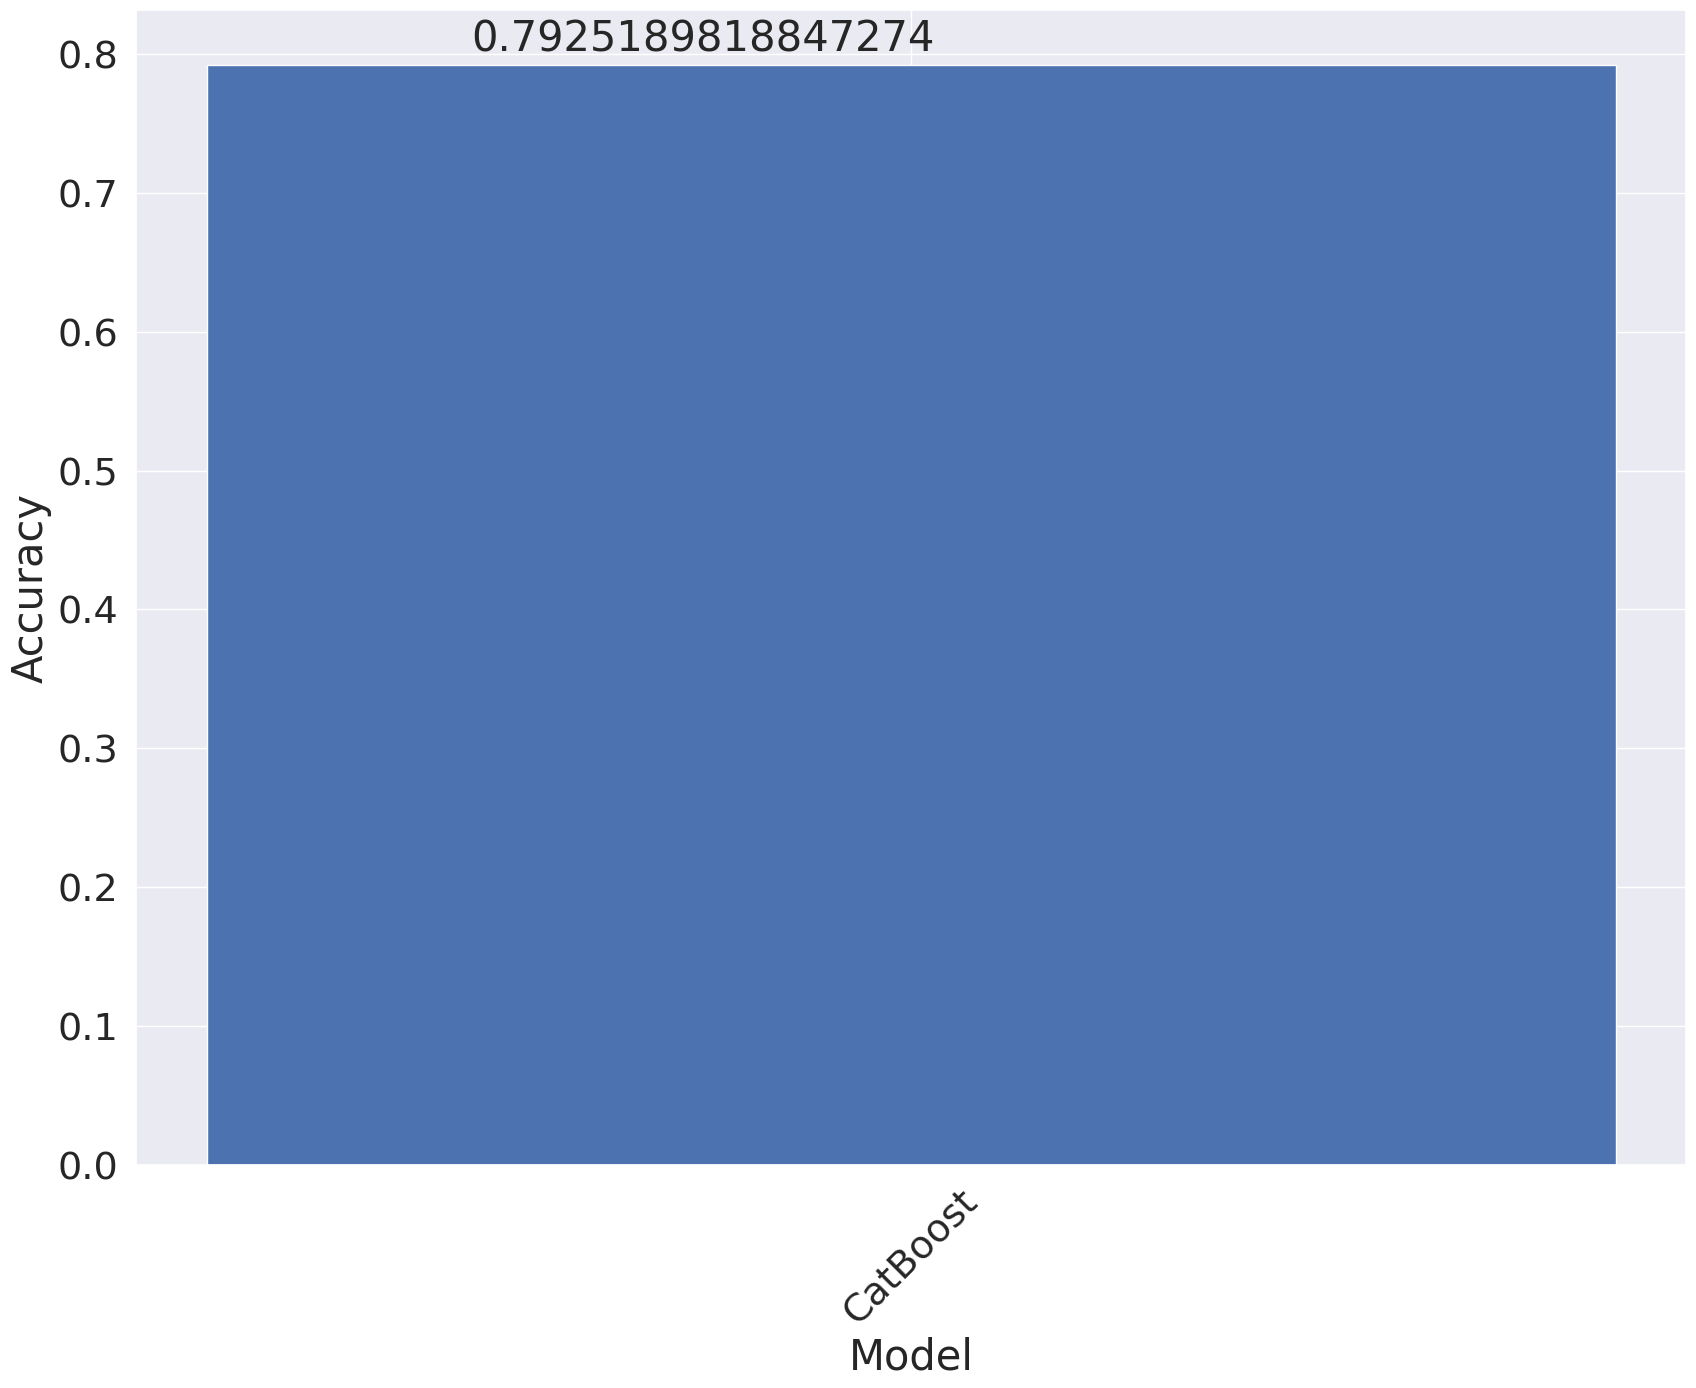

In [33]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [46]:
predictions_not = cat.predict(df.drop('target', axis = 1))
predictions_not

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
sum(predictions_not)/len(predictions_not)

0.9876157722062243

In [51]:
df

,loan_amnt,grade,annual_inc,delinq_2yrs,delinq_amnt,fico_range_high,fico_range_low,installment,mths_since_last_delinq,pub_rec_bankruptcies,target
0,6000.0,1,45000.0,1.0,0.0,759.0,755.0,187.94,22.0,0.0,1
2,23200.0,5,110000.0,1.0,0.0,674.0,670.0,680.82,10.0,0.0,0
5,16000.0,1,65000.0,0.0,0.0,824.0,820.0,494.55,0.0,0.0,0
6,4500.0,2,50000.0,0.0,0.0,704.0,700.0,146.10,0.0,2.0,1
7,20000.0,2,60000.0,0.0,0.0,679.0,675.0,645.25,40.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1755288,26500.0,3,60000.0,0.0,0.0,699.0,695.0,662.45,0.0,0.0,1
1755290,3600.0,5,33800.0,0.0,0.0,669.0,665.0,133.78,0.0,0.0,0
1755291,19000.0,1,71000.0,0.0,0.0,739.0,735.0,583.89,62.0,0.0,1
1755292,9600.0,3,44000.0,0.0,0.0,694.0,690.0,329.65,0.0,0.0,1


In [53]:
compare = pd.DataFrame()
compare['target'] = df['target']
compare['predictions_not'] = predictions_not

In [54]:
compare

,target,predictions_not
0,1,1
2,0,1
5,0,1
6,1,1
7,1,1
...,...,...
1755288,1,1
1755290,0,1
1755291,1,1
1755292,1,1


from matplotlib import pyplot as plt
compare['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
compare['predictions_not'].plot(kind='hist', bins=20, title='predictions_not')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
compare.plot(kind='scatter', x='target', y='predictions_not', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
compare['target'].plot(kind='line', figsize=(8, 4), title='target')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
compare['predictions_not'].plot(kind='line', figsize=(8, 4), title='predictions_not')
plt.gca().spines[['top', 'right']].set_visible(False)

In [44]:
predictions = cat.predict(df_current.drop('loan_status', axis = 1))
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [48]:
print(sum(predictions))
print(len(predictions))

612982
618688


In [45]:
sum(predictions)/len(predictions)

0.9907772576807696

## Shap 추가
출처 : https://todayisbetterthanyesterday.tistory.com/57

In [ ]:
explainer = shap.TreeExplainer(xgboost) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)
